In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit_machine_learning.neural_networks import EstimatorQNN,SamplerQNN
from IPython.display import clear_output
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
import time 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
import numpy as np

import pickle 
import time
from qiskit.circuit.library import iSwapGate


from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

In [3]:
J=1
nQ = 7
n_qubits=3*nQ
sqrt_iSWAP = iSwapGate().power(1/2)

runSim =True

dtFactor=0.2
nSteps=30

noise = False
# directory="Z2_ZNE_first_nQ"+str(nQ*3)

# import os
# if not os.path.exists(directory):
#     os.makedirs(directory)
    
from matplotlib import colormaps
list(colormaps)
cmap = 'gist_heat'

f = 0.2
nSteps = 10
precision = 0.01
matter_defect=[11]
nShots = 100000 



initial_charge_position = n_qubits-matter_defect[0]
initial_charge = 10
initialKey = '101010101000101010101'
#initial_charge = 25
#initialKey = '101010101010101010101010100010101010101010101010101'
initialKey[initial_charge_position]


'0'

In [4]:
def add3Q(circuit,tmpIndex,alpha=J):
    tmpIndex1=(tmpIndex+1)%(n_qubits)
    tmpIndex2=(tmpIndex+2)%(n_qubits)
    
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    #circuit.barrier()
    circuit.rz(np.pi,tmpIndex)
    circuit.rz(-np.pi/4,tmpIndex1)
    circuit.rz(-np.pi/4,tmpIndex2)
    circuit.append(sqrt_iSWAP, [tmpIndex1, tmpIndex2])
    
    circuit.rz(np.pi-alpha,tmpIndex1)
    circuit.rz(alpha,tmpIndex2)
    circuit.append(sqrt_iSWAP, [tmpIndex1, tmpIndex2])
    circuit.rz(np.pi/4,tmpIndex1)
    circuit.rz(np.pi/4,tmpIndex2)
    #circuit.barrier()
            
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    circuit.append(sqrt_iSWAP, [tmpIndex, tmpIndex1])
    
    
def getTrotterCircuit(n_qubits,J,nTrotter=2,fFactor=0.2,dtFactor=0.2,matter_defect=[11],measure=True):
    f=fFactor*J
    dt=dtFactor/J
    
    circuit = QuantumCircuit(n_qubits)
    #circuit = QuantumCircuit(n_qubits,n_qubits)
    
    #First produce the initial state:
    for i in range(n_qubits):
        defect_flag=False

        for index in matter_defect:
            if i== index - 1:
                defect_flag=True

        if defect_flag==False:
            if i%2!=0:
                circuit.h(i)
                
            else:
                circuit.x(i)
 
    #Trotterization:
    for step in range(nTrotter):
        
        circuit.barrier()
        
        
        
        for i in range(int(n_qubits/4)):
            tmpIndex=i*4
            add3Q(circuit,tmpIndex,alpha=J*dt)
        circuit.barrier()
        
        n_end=0# no period
        for i in range(int(n_qubits/4)-n_end):
            tmpIndex=i*4+2
            add3Q(circuit,tmpIndex,alpha=J*dt)
        circuit.barrier()
        
        
        
        for i in range(int(n_qubits/2)):
            tmpIndex=i*2
            circuit.rz(0,tmpIndex)
            circuit.rx(f*dt,tmpIndex+1)
        #Adding last rotation gate if it is an odd number
        if tmpIndex+1 == n_qubits-2:
            circuit.rz(0,tmpIndex+2)
        
    for i in range(n_qubits):
        if i%2 ==1:
            circuit.h(i)
    
    if measure:
        circuit.measure_all()
    return circuit
    



def getOB(isa_qc):
    observable_list=[]
    for i in range(n_qubits):
        if i%2!=0:
            observable = SparsePauliOp.from_list([("I"*(n_qubits-i-1)+"X"+"I"*(i) , 1)])
            observable = observable.apply_layout(layout=isa_qc.layout)
            observable_list.append(observable)

        else:

            observable = SparsePauliOp.from_list([("I"*(n_qubits-i-1)+"Z"+"I"*(i) , -1)])
            observable = observable.apply_layout(layout=isa_qc.layout)
            observable_list.append(observable)
    
    return observable_list


In [5]:
def checkZ2Charge(key):
    charge = []
    firstCharge_pos = 0
    for i in np.arange(0,len(key),1): # Assuming first and last are matter site.
        #assuming matter sites are all even
        #it is backward!

        if i%2 == 0:
            charge.append(int(key[i]))
            if int(key[i]) == 0:
                firstCharge_pos = i 
            
    charge = np.array(charge)

    return charge.sum(),firstCharge_pos,charge

def getEVs(string,wiggleRoom = 0,initialKey = initialKey):
    out = np.zeros(n_qubits)
    shots = 0
    
    n_charge = []
    
    for key in list(string.keys()):
                
        
        charge, charge_position,charge_arr = checkZ2Charge(key)
        for j in range(string[key]):
            n_charge.append(charge - initial_charge)
        
        if abs(charge - initial_charge) > wiggleRoom:
            continue
    
        tmpKey = np.array([int(numeric_string) for numeric_string in initialKey])  

        if charge_position == initial_charge_position:
            tmpKey = tmpKey #do nothing

        else:
            
            tmpKey[initial_charge_position] = 1
            tmpKey[charge_position] = 0
            #then flip the links
            
            if charge_position > initial_charge_position:
                for pos in np.arange(initial_charge_position+1,charge_position,1):
                    if pos%2 ==1: #flip link
                        tmpKey[pos] = 1
                        
            else:
                for pos in np.arange(charge_position+1, initial_charge_position,1):
            
                    if pos%2 ==1: #flip link
                        tmpKey[pos] = 1
                  
  
        arr = 1 -2*tmpKey #|0> to have eigenValue of 1, and |1> to have -1.
        
        for i in range(arr.shape[0]): #introduce a negative sign for all the matter site
            if i%2==0:
                arr[i] = -arr[i]
        

        out += arr*string[key]
        shots += string[key]
    output = out/shots
    
    return (output+1)/2, np.array(n_charge)


Aim to do the same time evolution but with different trotter steps. 
Make sure that dtFact * nTrotter is fixed!

In [6]:
time_total = 0.2*6
#nTrotter_list = [1,2,3,4,5,6,8,10,12]
nTrotter_list = [1,2,3,4,5,6,8]

In [9]:
if runSim:
    
    aer = AerSimulator()

    if noise:
        service = QiskitRuntimeService()
        real_backend = service.backend("ibm_kyoto")
        aer_sim = AerSimulator.from_backend(real_backend)
        estimator_sim = Estimator(mode=aer_sim)
        pm_sim = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)

    else:

        estimator_sim = Estimator( mode = aer)
        sampler_sim = Sampler(mode = aer)
        pm_sim = generate_preset_pass_manager(backend=aer, optimization_level=3)
        
        
    evs_list_truth = []
    for nTrotter in nTrotter_list:
        print(nTrotter)
        dtF = time_total/nTrotter
        circuit = getTrotterCircuit(n_qubits,J,nTrotter=nTrotter,fFactor=f,dtFactor=dtF,matter_defect=matter_defect)
        
        isa_qc = pm_sim.run(circuit)
        job = sampler_sim.run([(isa_qc,[])],shots = nShots)
        result = job.result()

        string = result[0].data.meas.get_counts()
        evs,charge = getEVs(string)
        evs_list_truth.append(evs)
        print(evs)
    evs_list_truth = np.array(evs_list_truth)
    np.save("evs_list_simulation_trotter.npy",evs_list_truth)

1
[1.      1.      1.      1.      1.      1.      1.      1.      0.88608
 0.88608 0.98316 0.13076 0.88542 0.24534 0.24534 1.      1.      1.
 1.      1.      1.     ]
2
[1.      1.      1.      1.      0.9777  0.9777  0.95225 0.92995 0.76274
 0.69269 0.99614 0.31117 0.76309 0.54808 0.57999 0.96809 0.97778 0.99031
 0.99031 1.      1.     ]
3
[0.99992 0.99992 0.99967 0.99959 0.96967 0.96926 0.91736 0.88662 0.74792
 0.63454 0.99611 0.36935 0.74086 0.62849 0.66972 0.95877 0.96885 0.98992
 0.99003 0.99989 0.99989]
4
[0.99986 0.99986 0.99924 0.9991  0.96696 0.96606 0.89521 0.86127 0.73659
 0.59786 0.99643 0.40571 0.73987 0.66584 0.70921 0.95663 0.96526 0.99137
 0.99154 0.99983 0.99983]
5
[0.99983 0.99983 0.99862 0.99845 0.96386 0.96231 0.88074 0.84305 0.73458
 0.57763 0.99637 0.426   0.73676 0.68924 0.73311 0.95613 0.96399 0.99214
 0.99236 0.99978 0.99978]
6
[0.99982 0.99982 0.99825 0.99807 0.96337 0.96144 0.87083 0.83227 0.73268
 0.56495 0.9965  0.43855 0.73216 0.70639 0.74986 0.95653 0.9

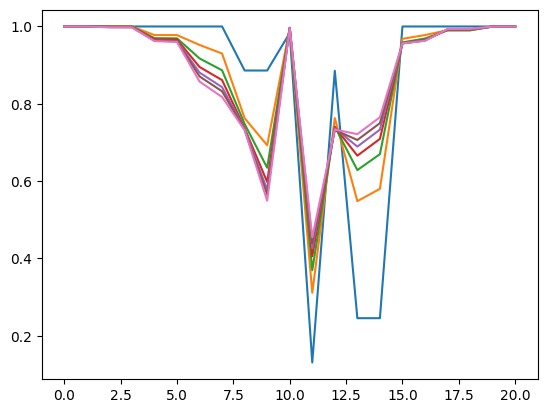

In [10]:
plt.plot(evs_list_truth.T);

Hardware

In [15]:
# from qiskit_ibm_runtime import QiskitRuntimeService
# # Save an IBM Quantum account and set it as your default account.
# service = QiskitRuntimeService(channel="ibm_quantum",instance="utokyo-kawasaki/internal/icepp-r5",token="")
# QiskitRuntimeService.save_account(channel="ibm_quantum",overwrite=True,instance="utokyo-kawasaki/internal/icepp-r5", token="86a8c6f00ee915610465242b9c54b2d98e97cf6e394a0de8014fa95a773b78becdd83b0cf0436a1d95d47ec83b0dc1cc008991f433b3d10166b3268cfffe953d", set_as_default=True)

# # service = QiskitRuntimeService(channel="ibm_quantum",instance="ibm-q-utokyo/internal/icepp-r5",token="86a8c6f00ee915610465242b9c54b2d98e97cf6e394a0de8014fa95a773b78becdd83b0cf0436a1d95d47ec83b0dc1cc008991f433b3d10166b3268cfffe953d")
# # QiskitRuntimeService.save_account(channel="ibm_quantum",overwrite=True,instance="ibm-q-utokyo/internal/icepp-r5", token="86a8c6f00ee915610465242b9c54b2d98e97cf6e394a0de8014fa95a773b78becdd83b0cf0436a1d95d47ec83b0dc1cc008991f433b3d10166b3268cfffe953d", set_as_default=True)

# #service = QiskitRuntimeService()

# service.backends()
# backend = service.backend("ibm_kawasaki")

# pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
# backend.status()
# n_jobs = np.array([1,1,4,4,10,20,30,50,50])


In [12]:
# jobs_dict = {}
# #jobs_list = []

# with Session(backend=backend) as session:
#     sampler_em = Sampler(mode = session)

#     sampler_em.options.dynamical_decoupling.enable = True
#     #sampler_em.options.dynamical_decoupling.sequence_type = "XY4"
    
    
#     sampler_em.options.twirling.enable_gates = True
#     #sampler_em.options.resilience.measure_mitigation = True


#     for i in range(len(nTrotter_list)):
#         print("current trotter size = ", i)
#         dtF = time_total/nTrotter_list[i]
#         jobs_id_list = []

#         for j in np.arange(0,n_jobs[i],1):
          
#             circuit = getTrotterCircuit(n_qubits,J,nTrotter=nTrotter_list[i],fFactor=f,dtFactor=dtF,matter_defect=matter_defect)
#             isa_qc = pm.run(circuit)


#             job = sampler_em.run([(isa_qc,[])],shots = nShots)
#             #jobs_list.append(job)

#             print(f"job ID: {job.job_id()}")
#             jobs_id_list.append(job.job_id())
            
#         jobs_dict[str(i)] =  jobs_id_list


In [16]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')
#name = "Kawasaki_51"+datetime.today().strftime('%Y-%m-%d')
name= "Kawasaki_512024-10-07"
print(name)

Kawasaki_512024-10-07


In [ ]:
# import pickle 
# print(name+'.pkl')
# with open(name+'.pkl', 'wb') as f:
#     pickle.dump(jobs_dict, f)
        

In [17]:
with open(name+'.pkl', 'rb') as f:
    jobs_dict = pickle.load(f)

In [18]:
string_list_dict = {}

for key in jobs_dict.keys():
    print(key)
    l = jobs_dict[key]
    string_list = []
    for job_id in l:
        print(job_id)
        job = service.job(job_id)
        r = job.result()
        string = r[0].data.meas.get_counts()
        string_list.append(string)
    string_list_dict[key] = string_list

1
cw1w3axvka8g008bb6a0
2
cw1w3bd4v2e0008shwe0
cw1w3c5vka8g008bb6ag
cw1w3cn54nq0008x7rdg
cw1w3ddvka8g008bb6b0
3
cw1w3dxrxqkg008e4dyg
cw1w3ed4v2e0008shweg
cw1w3ex54nq0008x7re0
cw1w3fdvka8g008bb6bg
4
cw1w3g6jz3x0008j90bg
cw1w3gpvka8g008bb6c0
cw1w3gy54nq0008x7reg
cw1w3hp79ws0008z4a60
cw1w3j6jz3x0008j90cg
cw1w3jp54nq0008x7rf0
cw1w3k6vka8g008bb6cg
cw1w3ky54nq0008x7rfg
cw1w3m6vka8g008bb6d0
cw1w3my54nq0008x7rg0
5
cw1w3ne79ws0008z4a6g
cw1w3ny54nq0008x7rgg
cw1w3pe4v2e0008shwf0
cw1w3py79ws0008z4a7g
cw1w3qe4v2e0008shwg0
cw1w3qy79ws0008z4a80
cw1w3rf79ws0008z4a8g
cw1w3rzvka8g008bb6e0
cw1w3sfvka8g008bb6eg
cw1w3sz79ws0008z4a90
cw1w3tq79ws0008z4a9g
cw1w3v7jz3x0008j90dg
cw1w3vq4v2e0008shwgg
cw1w3w779ws0008z4aa0
cw1w3wq54nq0008x7rh0
cw1w3xfjz3x0008j90e0
cw1w3xz79ws0008z4aag
cw1w3yf4v2e0008shwhg
cw1w3yz54nq0008x7rhg
cw1w3zf54nq0008x7rj0
6
cw1w3zz79ws0008z4abg
cw1w40879ws0008z4ac0
cw1w4104v2e0008shwjg
cw1w41g79ws0008z4acg
cw1w42079ws0008z4ad0
cw1w42g54nq0008x7rjg
cw1w4304v2e0008shwk0
cw1w43gjz3x0008j90eg
c

In [19]:
import json

with open(f'stringList_'+name+'.json', 'w') as fout:
    json.dump(string_list_dict, fout)

with open(f'stringList_'+name+'.json', 'r') as fin:
     string_list_dict = json.load(fin)


In [20]:
evs_list = []

for key in string_list_dict.keys():
    print(key)
    l = string_list_dict[key]
    evs_list_tmp = []
    charge_arr_list_tmp = []
    for string in l:
        evs= getEVs(string)[0]
        evs_list_tmp.append(evs)

        
    evs_list_tmp=np.array(evs_list_tmp)
    evs_list.append(evs_list_tmp.mean(axis=0))

evs_list = np.array(evs_list)  

1
2
3
4
5
6
8


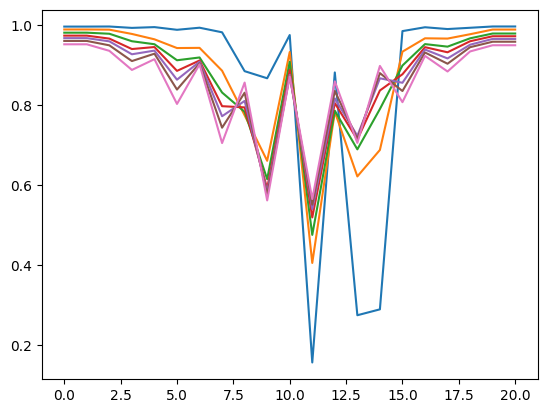

In [21]:
plt.plot(evs_list.T);

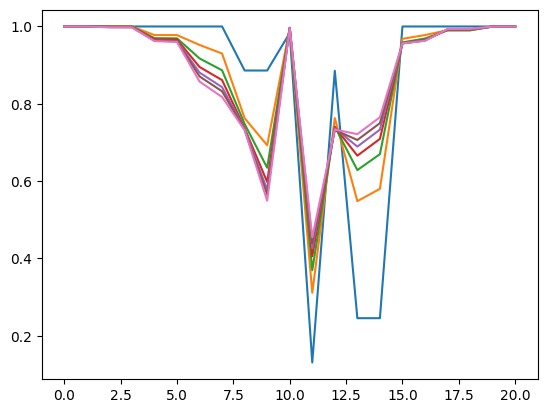

In [22]:
plt.plot(evs_list_truth.T);

In [209]:
def getChargeArr(evs):
    p_list = []
    for i in range(evs.shape[0]):
        if i%2==0:
            p=1-evs[i]
            p_list.append(p)
    return np.array(p_list)
            

In [210]:
prob_charge_truth = []
for evs in evs_list_truth:
    p = getChargeArr(evs)
    prob_charge_truth.append(p)
    
prob_charge_truth = np.array(prob_charge_truth)


prob_charge = []
for evs in evs_list:
    p = getChargeArr(evs)
    prob_charge.append(p)
    
prob_charge = np.array(prob_charge)

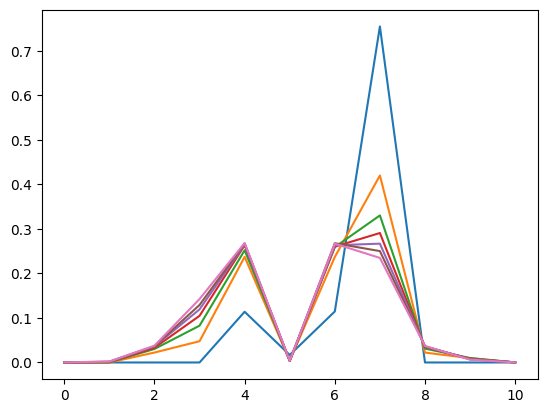

In [211]:
plt.plot(prob_charge_truth[:,:].T)
prob_charge_finalTruth = prob_charge_truth[-1,:]

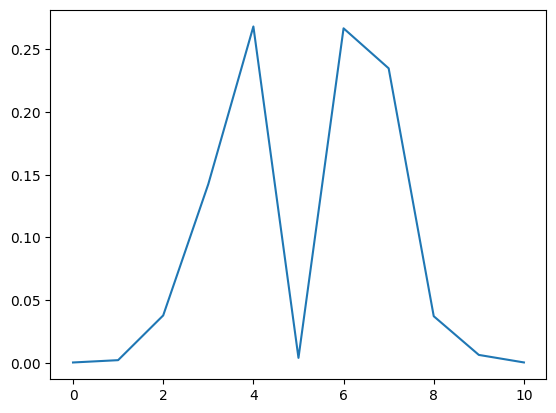

In [212]:
plt.plot(prob_charge_finalTruth)

In [214]:
from scipy import interpolate



In [215]:
expolate_min = 2

Text(0.5, 1.0, 'Charge probability at Site1')

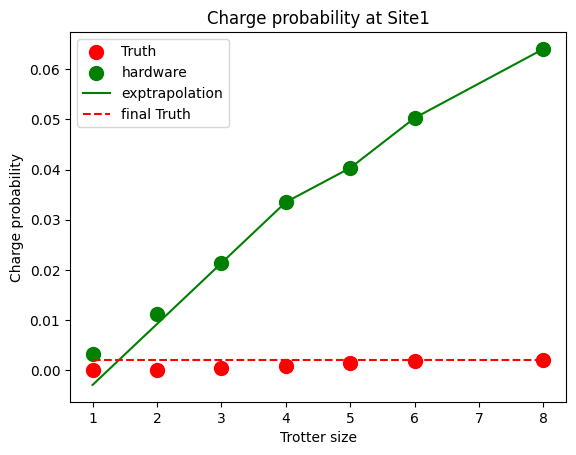

In [216]:
site = 1 
plt.scatter(nTrotter_list, prob_charge_truth[:,site ],label='Truth',color='r',s=100)
plt.scatter(nTrotter_list, prob_charge[:,site ],label='hardware',color='g',s=100)
f = interpolate.interp1d(nTrotter_list[expolate_min:], prob_charge[expolate_min:,site ],fill_value='extrapolate')
xx=np.arange(nTrotter_list[0],nTrotter_list[-1],0.01)
plt.plot(xx,f(xx),label='exptrapolation',color='g')
plt.hlines( prob_charge_truth[-1,site],nTrotter_list[0],nTrotter_list[-1], linestyle='--',color='r',label='final Truth')
plt.legend()
plt.xlabel('Trotter size')
plt.ylabel('Charge probability')
plt.title("Charge probability at Site"+str(site))

Text(0.5, 1.0, 'Charge probability at Site2')

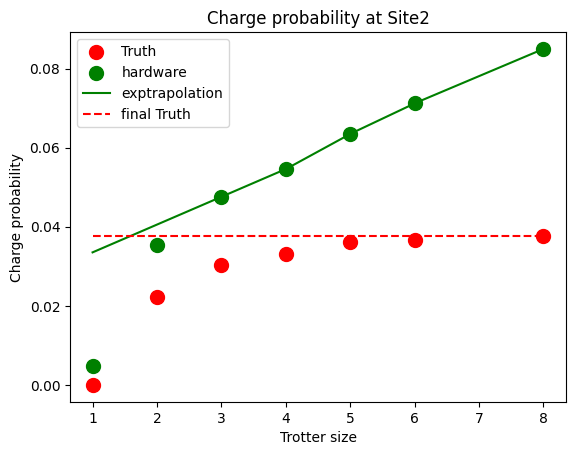

In [217]:
site = 2
plt.scatter(nTrotter_list, prob_charge_truth[:,site ],label='Truth',color='r',s=100)
plt.scatter(nTrotter_list, prob_charge[:,site ],label='hardware',color='g',s=100)
f = interpolate.interp1d(nTrotter_list[expolate_min:], prob_charge[expolate_min:,site ],fill_value='extrapolate')
xx=np.arange(nTrotter_list[0],nTrotter_list[-1],0.01)
plt.plot(xx,f(xx),label='exptrapolation',color='g')
plt.hlines( prob_charge_truth[-1,site],nTrotter_list[0],nTrotter_list[-1], linestyle='--',color='r',label='final Truth')
plt.legend()
plt.xlabel('Trotter size')
plt.ylabel('Charge probability')
plt.title("Charge probability at Site"+str(site))

Text(0.5, 1.0, 'Charge probability at Site3')

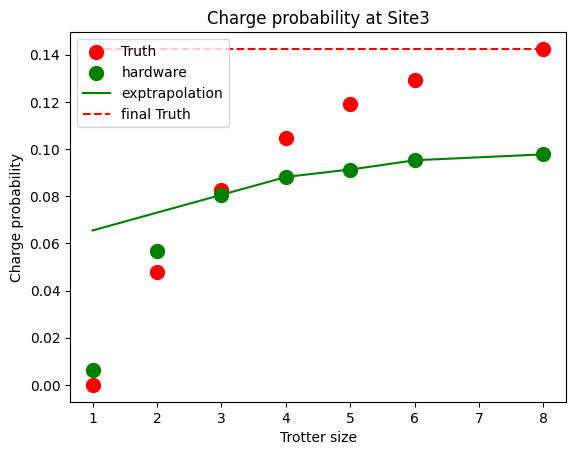

In [218]:
site = 3
plt.scatter(nTrotter_list, prob_charge_truth[:,site ],label='Truth',color='r',s=100)
plt.scatter(nTrotter_list, prob_charge[:,site ],label='hardware',color='g',s=100)
f = interpolate.interp1d(nTrotter_list[expolate_min:], prob_charge[expolate_min:,site ],fill_value='extrapolate')
xx=np.arange(nTrotter_list[0],nTrotter_list[-1],0.01)
plt.plot(xx,f(xx),label='exptrapolation',color='g')
plt.hlines( prob_charge_truth[-1,site],nTrotter_list[0],nTrotter_list[-1], linestyle='--',color='r',label='final Truth')
plt.legend()
plt.xlabel('Trotter size')
plt.ylabel('Charge probability')
plt.title("Charge probability at Site"+str(site))

Text(0.5, 1.0, 'Charge probability at Site4')

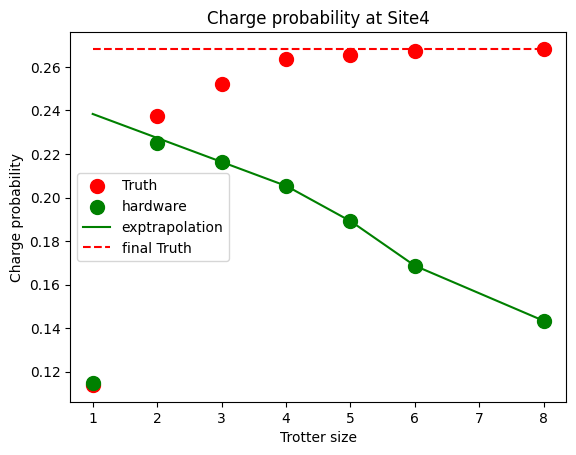

In [219]:
site = 4
plt.scatter(nTrotter_list, prob_charge_truth[:,site ],label='Truth',color='r',s=100)
plt.scatter(nTrotter_list, prob_charge[:,site ],label='hardware',color='g',s=100)
f = interpolate.interp1d(nTrotter_list[expolate_min:], prob_charge[expolate_min:,site ],fill_value='extrapolate')
xx=np.arange(nTrotter_list[0],nTrotter_list[-1],0.01)
plt.plot(xx,f(xx),label='exptrapolation',color='g')
plt.hlines( prob_charge_truth[-1,site],nTrotter_list[0],nTrotter_list[-1], linestyle='--',color='r',label='final Truth')
plt.legend()
plt.xlabel('Trotter size')
plt.ylabel('Charge probability')
plt.title("Charge probability at Site"+str(site))

Text(0.5, 1.0, 'Charge probability at Site5')

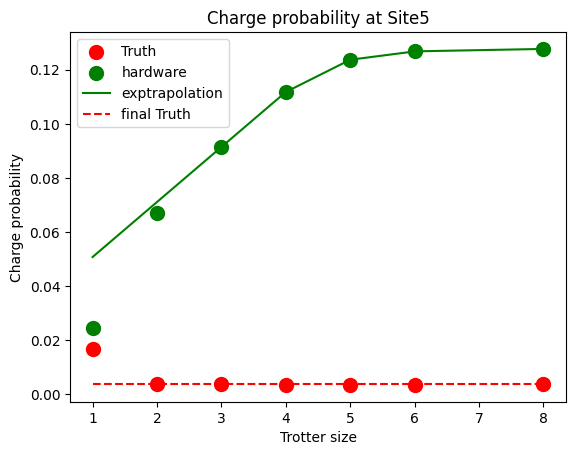

In [220]:
site = 5
plt.scatter(nTrotter_list, prob_charge_truth[:,site ],label='Truth',color='r',s=100)
plt.scatter(nTrotter_list, prob_charge[:,site ],label='hardware',color='g',s=100)
f = interpolate.interp1d(nTrotter_list[expolate_min:], prob_charge[expolate_min:,site ],fill_value='extrapolate')
xx=np.arange(nTrotter_list[0],nTrotter_list[-1],0.01)
plt.plot(xx,f(xx),label='exptrapolation',color='g')
plt.hlines( prob_charge_truth[-1,site],nTrotter_list[0],nTrotter_list[-1], linestyle='--',color='r',label='final Truth')
plt.legend()
plt.xlabel('Trotter size')
plt.ylabel('Charge probability')
plt.title("Charge probability at Site"+str(site))

Text(0.5, 1.0, 'Charge probability at Site6')

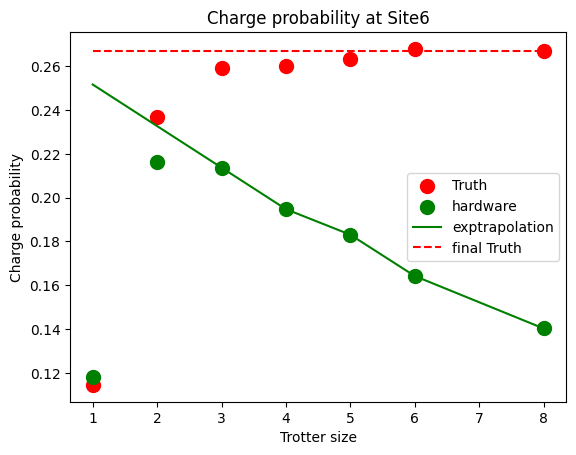

In [221]:
site = 6 
plt.scatter(nTrotter_list, prob_charge_truth[:,site ],label='Truth',color='r',s=100)
plt.scatter(nTrotter_list, prob_charge[:,site ],label='hardware',color='g',s=100)
f = interpolate.interp1d(nTrotter_list[expolate_min:], prob_charge[expolate_min:,site ],fill_value='extrapolate')
xx=np.arange(nTrotter_list[0],nTrotter_list[-1],0.01)
plt.plot(xx,f(xx),label='exptrapolation',color='g')
plt.hlines( prob_charge_truth[-1,site],nTrotter_list[0],nTrotter_list[-1], linestyle='--',color='r',label='final Truth')
plt.legend()
plt.xlabel('Trotter size')
plt.ylabel('Charge probability')
plt.title("Charge probability at Site"+str(site))

Text(0.5, 1.0, 'Charge probability at Site7')

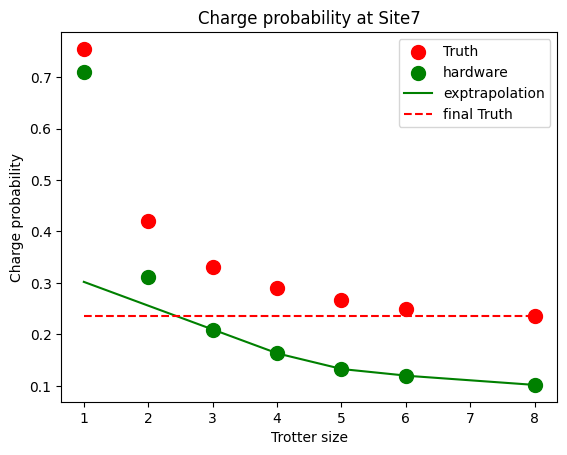

In [222]:
site = 7
plt.scatter(nTrotter_list, prob_charge_truth[:,site ],label='Truth',color='r',s=100)
plt.scatter(nTrotter_list, prob_charge[:,site ],label='hardware',color='g',s=100)
f = interpolate.interp1d(nTrotter_list[expolate_min:], prob_charge[expolate_min:,site ],fill_value='extrapolate')
xx=np.arange(nTrotter_list[0],nTrotter_list[-1],0.01)
plt.plot(xx,f(xx),label='exptrapolation',color='g')
plt.hlines( prob_charge_truth[-1,site],nTrotter_list[0],nTrotter_list[-1], linestyle='--',color='r',label='final Truth')
plt.legend()
plt.xlabel('Trotter size')
plt.ylabel('Charge probability')
plt.title("Charge probability at Site"+str(site))

Text(0.5, 1.0, 'Charge probability at Site8')

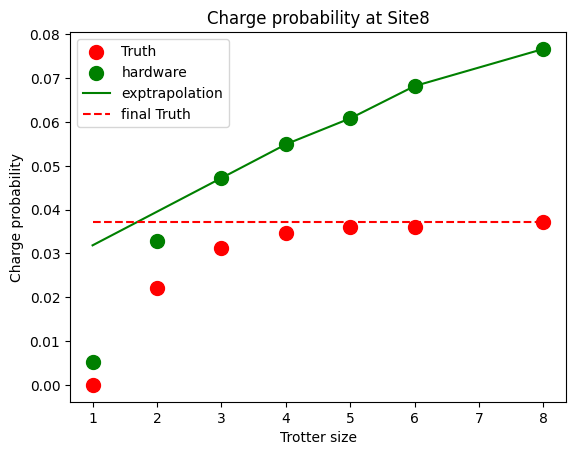

In [223]:
site = 8
plt.scatter(nTrotter_list, prob_charge_truth[:,site ],label='Truth',color='r',s=100)
plt.scatter(nTrotter_list, prob_charge[:,site ],label='hardware',color='g',s=100)
f = interpolate.interp1d(nTrotter_list[expolate_min:], prob_charge[expolate_min:,site ],fill_value='extrapolate')
xx=np.arange(nTrotter_list[0],nTrotter_list[-1],0.01)
plt.plot(xx,f(xx),label='exptrapolation',color='g')
plt.hlines( prob_charge_truth[-1,site],nTrotter_list[0],nTrotter_list[-1], linestyle='--',color='r',label='final Truth')
plt.legend()
plt.xlabel('Trotter size')
plt.ylabel('Charge probability')
plt.title("Charge probability at Site"+str(site))

In [231]:
def ZNE(prob_charge,expolate_min=2,norm=True):
    nSite = prob_charge.shape[1]
    out = []
    for site in range(nSite):
        f = interpolate.interp1d(nTrotter_list[expolate_min:], prob_charge[expolate_min:,site],fill_value='extrapolate')
        extrapolated = f(1)
        out.append(extrapolated)
        
    out = np.array(out)
    if norm:
        out[out<0]=0
        out = out/out.sum()
    return out
    

In [232]:
prob_charge_ZNE = ZNE(prob_charge,expolate_min=2)

<Figure size 640x480 with 0 Axes>

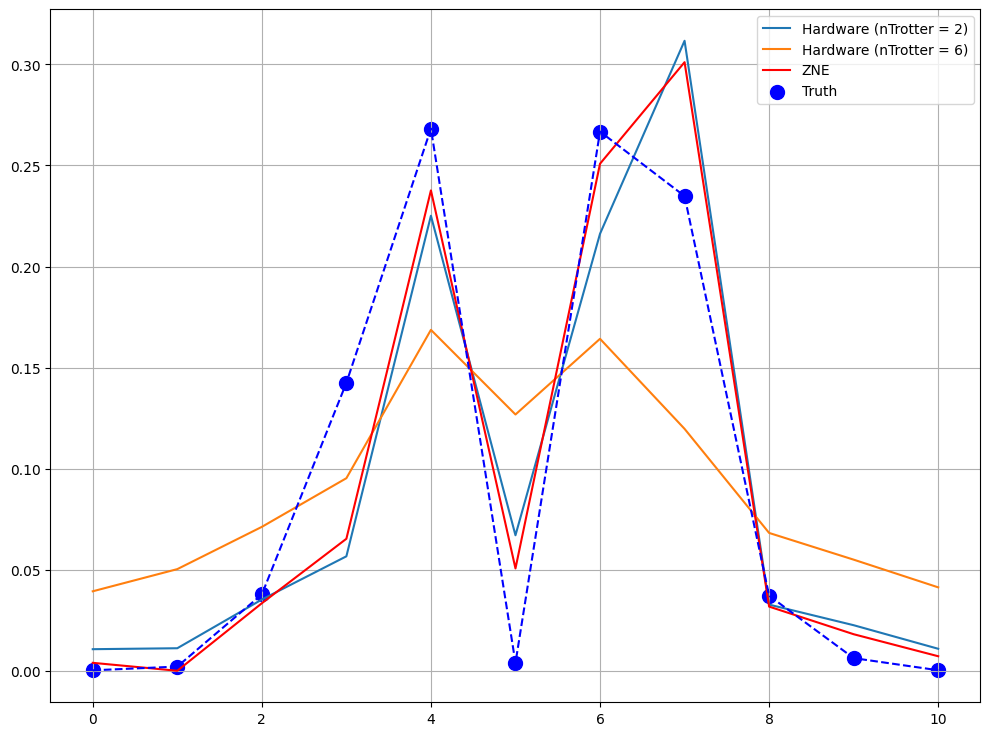

In [233]:
plt.figure(1)
plt.figure(figsize=(12,9))#plt.plot(prob_charge[0,:],label='Hardware (nTrotter = 1)')

#plt.plot(prob_charge[0,:],label='Hardware (nTrotter = 1)')
plt.plot(prob_charge[1,:],label='Hardware (nTrotter = 2)')
#plt.plot(prob_charge[2,:],label='Hardware (nTrotter = 3)')
plt.plot(prob_charge[5,:],label='Hardware (nTrotter = 6)')
plt.plot(prob_charge_ZNE,label='ZNE',color='r')
plt.scatter(range(len(prob_charge_finalTruth)),prob_charge_finalTruth,label='Truth',color='b',marker='o',s=100)
plt.plot(range(len(prob_charge_finalTruth)),prob_charge_finalTruth,linestyle='--',color='b')
plt.legend()
plt.grid()

In [236]:
prob_charge_finalTruth.sum()

1.0